<center> <font size="6"> <div class="alert alert-block alert-success"> <strong> A2Z Insurance Customer Segmentation Project 
</strong> </div> </font> </center>

<center> <font size="4"> <div class="alert alert-block alert-success"> <strong> SOM 
</strong> </div> </font> </center>

In [1]:
import warnings
warnings.filterwarnings('ignore')

#!pip install sas7bdat

import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from math import ceil

from sklearn.impute import KNNImputer

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier
from scipy.cluster.hierarchy import dendrogram

from matplotlib.lines import Line2D
import seaborn as sns

from matplotlib import __version__ as mplver
plt.rcParams['figure.dpi'] = 50

from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth

import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView

#! pip install minisom
from minisom import MiniSom
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib import colors as mpl_colors

## Import Data

In [2]:
#import data
df_ohc=pd.read_csv('preproc_data.csv')

df_ohc = df_ohc.rename(columns={"x0_b'2 - High School'":'High School', 
                              "x0_b'3 - BSc/MSc'":'BSc/MSc', 
                              "x0_b'4 - PhD'":'PhD', 
                              'x1_Diamond':'Diamond', 
                              'x1_Gold':'Gold', 
                              'x1_Silver':'Silver',
                              })

In [3]:
#define perspectives
demo =  df_ohc[['High School', 'BSc/MSc', 'PhD',
       'MonthSal', 'Children']].copy()

cust_val =  df_ohc[['CustMonVal','Client Tenure', 'Total Premium']].copy()

## SOM Models

### Perspective 1: Customer Value

#### SOM

In [4]:
np.random.seed(42)

sm = sompy.SOMFactory().build(
    cust_val.values, 
    mapsize=[8,8],
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=cust_val.columns
)
sm.train(n_job=-1, verbose='info', train_rough_len=100, train_finetune_len=100)

 Training...
 random_initialization took: 0.000000 seconds
 Rough training...
 radius_ini: 3.000000 , radius_final: 1.000000, trainlen: 100

 epoch: 1 ---> elapsed time:  0.119000, quantization error: 1.790693

 epoch: 2 ---> elapsed time:  0.142000, quantization error: 1.407225

 epoch: 3 ---> elapsed time:  0.135000, quantization error: 1.343868

 epoch: 4 ---> elapsed time:  0.114000, quantization error: 1.274111

 epoch: 5 ---> elapsed time:  0.148000, quantization error: 1.253940

 epoch: 6 ---> elapsed time:  0.149000, quantization error: 1.241323

 epoch: 7 ---> elapsed time:  0.135000, quantization error: 1.226048

 epoch: 8 ---> elapsed time:  0.145000, quantization error: 1.220020

 epoch: 9 ---> elapsed time:  0.122000, quantization error: 1.216564

 epoch: 10 ---> elapsed time:  0.133000, quantization error: 1.213504

 epoch: 11 ---> elapsed time:  0.132000, quantization error: 1.210268

 epoch: 12 ---> elapsed time:  0.118000, quantization error: 1.207279

 epoch: 13 ---> 

 epoch: 14 ---> elapsed time:  0.131000, quantization error: 0.589263

 epoch: 15 ---> elapsed time:  0.123000, quantization error: 0.589252

 epoch: 16 ---> elapsed time:  0.123000, quantization error: 0.589251

 epoch: 17 ---> elapsed time:  0.126000, quantization error: 0.589246

 epoch: 18 ---> elapsed time:  0.129000, quantization error: 0.589233

 epoch: 19 ---> elapsed time:  0.104000, quantization error: 0.589226

 epoch: 20 ---> elapsed time:  0.139000, quantization error: 0.589226

 epoch: 21 ---> elapsed time:  0.143000, quantization error: 0.589226

 epoch: 22 ---> elapsed time:  0.136000, quantization error: 0.589224

 epoch: 23 ---> elapsed time:  0.121000, quantization error: 0.589218

 epoch: 24 ---> elapsed time:  0.127000, quantization error: 0.589213

 epoch: 25 ---> elapsed time:  0.148000, quantization error: 0.589213

 epoch: 26 ---> elapsed time:  0.134000, quantization error: 0.589217

 epoch: 27 ---> elapsed time:  0.133000, quantization error: 0.589217

 epoch

* Components Planes

In [5]:
def plot_component_planes(weights,
                          features,
                          M=3, N=4, 
                          figsize=(20,20),
                          figlayout=(3,4),
                          title="Component Planes",
                          cmap=cm.magma
                         ):
    
    xx, yy = np.meshgrid(np.arange(M), np.arange(N))
    xx = xx.astype(float)
    yy = yy.astype(float)

    xx[::-2] -= 0.5

    xx = xx.T
    yy = yy.T
    
    weights_ = weights.reshape((M,N,len(features)))

    fig = plt.figure(figsize=figsize, constrained_layout=True)
    subfigs = fig.subfigures(figlayout[0], figlayout[1], wspace=.15)
    
    ## Normalize color scale to range of all values
    colornorm = mpl_colors.Normalize(vmin=np.min(weights), 
                                         vmax=np.max(weights))

    for cpi, sf in zip(range(len(metric_features)), subfigs.flatten()):

        sf.suptitle(features[cpi], y=0.95)

        axs = sf.subplots(1,1, )
        axs.set_aspect('equal')

        ## Normalize color scale to range of values in each component
        colornorm = mpl_colors.Normalize(vmin=np.min(weights_[:,:,cpi]), 
                                         vmax=np.max(weights_[:,:,cpi]))

        # iteratively add hexagons
        for i in range(weights_.shape[0]):
            for j in range(weights_.shape[1]):
                wy = yy[(i, j)] * np.sqrt(3) / 2
                hexagon = RegularPolygon((xx[(i, j)], wy), 
                                     numVertices=6, 
                                     radius=.99 / np.sqrt(3),
                                     facecolor=cmap(colornorm(weights_[i, j, cpi])), 
                                     alpha=1, 
                                     linewidth=.5,
                                     edgecolor=cmap(colornorm(weights_[i, j, cpi]))
                                    )
                axs.add_patch(hexagon)


        ## only run this block if matplotlib >= 3.6.x
        mplv = [int(i) for i in mplver.split('.')]
        if mplv[1] >= 6:
            ## Add colorbar
            divider = make_axes_locatable(axs)

            ax_cb = divider.append_axes("right", size="7%")#, pad="2%")

            ## Create a Mappable object
            cmap_sm = plt.cm.ScalarMappable(cmap=cmap, norm=colornorm)
            cmap_sm.set_array([])

            ## Create custom colorbar 
            cb1 = colorbar.Colorbar(ax_cb,
                                    orientation='vertical', 
                                    alpha=1,
                                    mappable=cmap_sm
                                    )
            cb1.ax.get_yaxis().labelpad = 16

            ## Add colorbar to plot
            sf.add_axes(ax_cb)



        ## Remove axes for hex plot
        axs.margins(.05)
        axs.axis("off")


    fig.suptitle(title)
    plt.show()

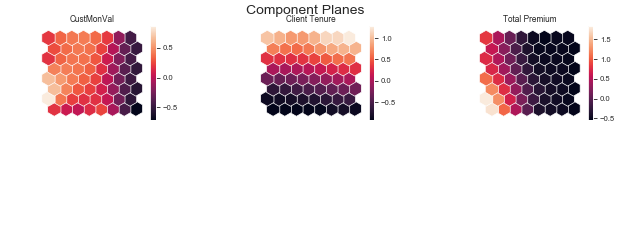

In [6]:
sns.set()
view2D = View2D(12,12,"", text_size=10)
view2D.show(sm, col_sz=3, what='codebook')
plt.subplots_adjust(top=0.90)
plt.suptitle("Component Planes", fontsize=20)
plt.show()

* U-Matrix

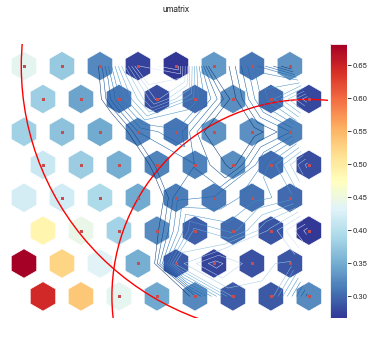

In [7]:
u = sompy.umatrix.UMatrixView(9, 9, 'umatrix', show_axis=True, text_size=8, show_text=True)

UMAT = u.show(
    sm, 
    distance=2, 
    row_normalized=False, 
    show_data=False, 
    contour=True, # Visualize isomorphic curves
    blob=True
)

* Hit-map

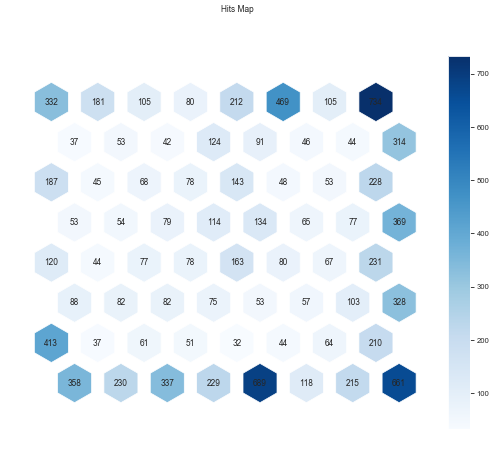

In [8]:
vhts  = BmuHitsView(12,12,"Hits Map")
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=12, cmap="Blues")
plt.show()

#### Emergent SOM

In [9]:
'''np.random.seed(42)

sm = sompy.SOMFactory().build(
    cust_val.values, 
    mapsize=[50, 50],  # NEEDS TO BE A LIST
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=cust_val.columns
)
sm.train(n_job=-1, verbose='info', train_rough_len=100, train_finetune_len=100)

#coordinates of the units
(sm.codebook.matrix[:,0]).std()

#component planes
sns.set()
view2D = View2D(12,12,"", text_size=10)
view2D.show(sm, col_sz=3, what='codebook')
plt.subplots_adjust(top=0.90)
plt.suptitle("Component Planes", fontsize=20)
plt.show()

#u-Matrix
u = sompy.umatrix.UMatrixView(9, 9, 'umatrix', show_axis=True, text_size=8, show_text=True)

UMAT = u.show(
    sm, 
    distance=2, 
    row_normalized=False, 
    show_data=False, 
    contour=True 
)'''

'np.random.seed(42)\n\nsm = sompy.SOMFactory().build(\n    cust_val.values, \n    mapsize=[50, 50],  # NEEDS TO BE A LIST\n    initialization=\'random\',\n    neighborhood=\'gaussian\',\n    training=\'batch\',\n    lattice=\'hexa\',\n    component_names=cust_val.columns\n)\nsm.train(n_job=-1, verbose=\'info\', train_rough_len=100, train_finetune_len=100)\n\n#coordinates of the units\n(sm.codebook.matrix[:,0]).std()\n\n#component planes\nsns.set()\nview2D = View2D(12,12,"", text_size=10)\nview2D.show(sm, col_sz=3, what=\'codebook\')\nplt.subplots_adjust(top=0.90)\nplt.suptitle("Component Planes", fontsize=20)\nplt.show()\n\n#u-Matrix\nu = sompy.umatrix.UMatrixView(9, 9, \'umatrix\', show_axis=True, text_size=8, show_text=True)\n\nUMAT = u.show(\n    sm, \n    distance=2, \n    row_normalized=False, \n    show_data=False, \n    contour=True \n)'

#### K-Means on top of SOM Units

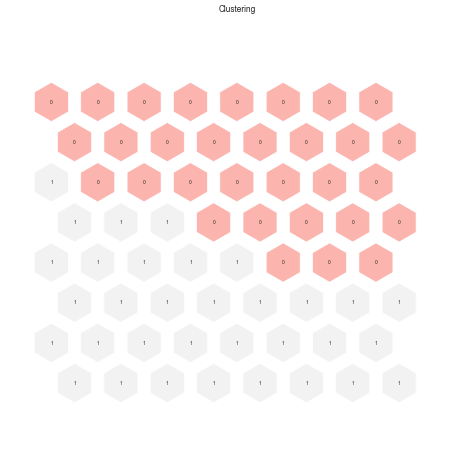

In [10]:
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=20, random_state=42)
nodeclus_labels = kmeans.fit_predict(sm.codebook.matrix)
sm.cluster_labels = nodeclus_labels  # setting the cluster labels of sompy

hits = HitMapView(12, 12,"Clustering", text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [11]:
nodes = sm.codebook.matrix
df_nodes = pd.DataFrame(nodes, columns=cust_val.columns)
df_nodes['label_somkm'] = nodeclus_labels
df_nodes

,CustMonVal,Client Tenure,Total Premium,label_somkm
0,-0.437455,1.277004,-0.509464,0
1,-0.142573,1.162629,-0.503013,0
2,0.213812,1.153599,-0.545867,0
3,0.371242,0.952858,-0.473928,0
4,0.426828,0.819753,-0.247448,0
...,...,...,...,...
59,0.247544,-0.899064,-0.369719,1
60,0.163059,-0.912644,0.002671,1
61,0.030004,-0.918687,0.480804,1
62,0.067107,-0.917587,1.075575,1


In [12]:
bmus_map = sm.find_bmu(np.array(cust_val))[0]

df_bmus = pd.DataFrame(
    np.concatenate((cust_val, np.expand_dims(bmus_map,1)), axis=1),
    index=cust_val.index, columns=np.append(cust_val.columns,"BMU_somkm")
)
df_bmus

,CustMonVal,Client Tenure,Total Premium,BMU_somkm
0,0.900222,0.576923,0.126701,13.0
1,0.869682,0.192308,0.251557,21.0
2,0.907599,0.346154,0.164880,21.0
3,0.876488,0.384615,0.093691,21.0
4,0.879603,0.538462,0.108222,13.0
...,...,...,...,...
10236,0.877495,0.615385,0.114490,13.0
10237,0.961327,0.884615,0.515942,6.0
10238,0.908757,0.230769,0.142310,21.0
10239,0.892414,0.730769,0.182341,5.0


In [13]:
df_custval = df_bmus.merge(df_nodes['label_somkm'], 'left', left_on="BMU_somkm", right_index=True)
df_custval

,CustMonVal,Client Tenure,Total Premium,BMU_somkm,label_somkm
0,0.900222,0.576923,0.126701,13.0,0
1,0.869682,0.192308,0.251557,21.0,0
2,0.907599,0.346154,0.164880,21.0,0
3,0.876488,0.384615,0.093691,21.0,0
4,0.879603,0.538462,0.108222,13.0,0
...,...,...,...,...,...
10236,0.877495,0.615385,0.114490,13.0,0
10237,0.961327,0.884615,0.515942,6.0,0
10238,0.908757,0.230769,0.142310,21.0,0
10239,0.892414,0.730769,0.182341,5.0,0


In [14]:
df_custval.drop(columns='BMU_somkm').groupby('label_somkm').mean()

,CustMonVal,Client Tenure,Total Premium
label_somkm,,,
0,0.889495,0.520669,0.155820
1,0.895126,0.131007,0.294445


#### Hierarchical Clustering on top of SOM Units

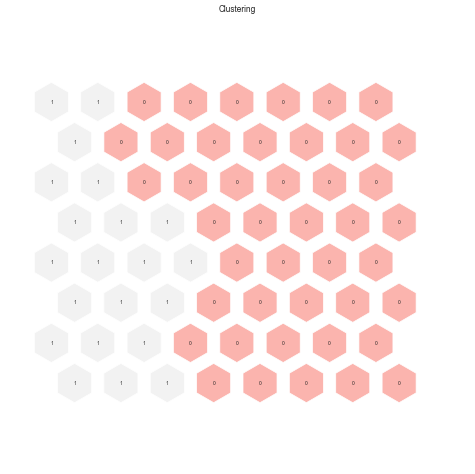

In [15]:
hierclust = AgglomerativeClustering(n_clusters=2, linkage='ward')
nodeclus_labels = hierclust.fit_predict(sm.codebook.matrix)
sm.cluster_labels = nodeclus_labels  # setting the cluster labels of sompy

hits  = HitMapView(12, 12,"Clustering",text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [16]:
nodes = sm.codebook.matrix
df_nodes = pd.DataFrame(nodes, columns=cust_val.columns)
df_nodes['label_somhc'] = nodeclus_labels
df_nodes

,CustMonVal,Client Tenure,Total Premium,label_somhc
0,-0.437455,1.277004,-0.509464,0
1,-0.142573,1.162629,-0.503013,0
2,0.213812,1.153599,-0.545867,0
3,0.371242,0.952858,-0.473928,0
4,0.426828,0.819753,-0.247448,0
...,...,...,...,...
59,0.247544,-0.899064,-0.369719,0
60,0.163059,-0.912644,0.002671,0
61,0.030004,-0.918687,0.480804,1
62,0.067107,-0.917587,1.075575,1


In [17]:
bmus_map = sm.find_bmu(np.array(cust_val))[0]  # get bmus for each observation in df

df_bmus = pd.DataFrame(
    np.concatenate((cust_val, np.expand_dims(bmus_map,1)), axis=1),
    index=cust_val.index, columns=np.append(cust_val.columns,"BMU_somhc")
)
df_bmus

,CustMonVal,Client Tenure,Total Premium,BMU_somhc
0,0.900222,0.576923,0.126701,13.0
1,0.869682,0.192308,0.251557,21.0
2,0.907599,0.346154,0.164880,21.0
3,0.876488,0.384615,0.093691,21.0
4,0.879603,0.538462,0.108222,13.0
...,...,...,...,...
10236,0.877495,0.615385,0.114490,13.0
10237,0.961327,0.884615,0.515942,6.0
10238,0.908757,0.230769,0.142310,21.0
10239,0.892414,0.730769,0.182341,5.0


In [18]:
df_custval2 = df_bmus.merge(df_nodes['label_somhc'], 'left', left_on="BMU_somhc", right_index=True)
df_custval2

,CustMonVal,Client Tenure,Total Premium,BMU_somhc,label_somhc
0,0.900222,0.576923,0.126701,13.0,0
1,0.869682,0.192308,0.251557,21.0,0
2,0.907599,0.346154,0.164880,21.0,0
3,0.876488,0.384615,0.093691,21.0,0
4,0.879603,0.538462,0.108222,13.0,0
...,...,...,...,...,...
10236,0.877495,0.615385,0.114490,13.0,0
10237,0.961327,0.884615,0.515942,6.0,1
10238,0.908757,0.230769,0.142310,21.0,0
10239,0.892414,0.730769,0.182341,5.0,0


In [19]:
df_custval2.drop(columns='BMU_somhc').groupby('label_somhc').mean()

,CustMonVal,Client Tenure,Total Premium
label_somhc,,,
0,0.889337,0.520334,0.152349
1,0.895761,0.166393,0.307126


### Perspective 2: Customer Demography

#### SOM

* SOM

In [20]:
np.random.seed(42)

sm = sompy.SOMFactory().build(
    demo.values, 
    mapsize=[7, 7], 
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=demo.columns
)
sm.train(n_job=-1, verbose='info', train_rough_len=100, train_finetune_len=100)

 Training...
 random_initialization took: 0.000000 seconds
 Rough training...
 radius_ini: 3.000000 , radius_final: 1.000000, trainlen: 100

 epoch: 1 ---> elapsed time:  0.153000, quantization error: 1.410298

 epoch: 2 ---> elapsed time:  0.116000, quantization error: 2.022039

 epoch: 3 ---> elapsed time:  0.118000, quantization error: 1.961957

 epoch: 4 ---> elapsed time:  0.115000, quantization error: 1.936118

 epoch: 5 ---> elapsed time:  0.117000, quantization error: 1.899916

 epoch: 6 ---> elapsed time:  0.132000, quantization error: 1.890016

 epoch: 7 ---> elapsed time:  0.119000, quantization error: 1.886275

 epoch: 8 ---> elapsed time:  0.118000, quantization error: 1.880564

 epoch: 9 ---> elapsed time:  0.130000, quantization error: 1.873444

 epoch: 10 ---> elapsed time:  0.128000, quantization error: 1.867602

 epoch: 11 ---> elapsed time:  0.122000, quantization error: 1.863762

 epoch: 12 ---> elapsed time:  0.120000, quantization error: 1.859890

 epoch: 13 ---> 

 epoch: 14 ---> elapsed time:  0.133000, quantization error: 0.806398

 epoch: 15 ---> elapsed time:  0.119000, quantization error: 0.804556

 epoch: 16 ---> elapsed time:  0.129000, quantization error: 0.801657

 epoch: 17 ---> elapsed time:  0.118000, quantization error: 0.799177

 epoch: 18 ---> elapsed time:  0.117000, quantization error: 0.799098

 epoch: 19 ---> elapsed time:  0.133000, quantization error: 0.799103

 epoch: 20 ---> elapsed time:  0.151000, quantization error: 0.799099

 epoch: 21 ---> elapsed time:  0.118000, quantization error: 0.799099

 epoch: 22 ---> elapsed time:  0.161000, quantization error: 0.799099

 epoch: 23 ---> elapsed time:  0.155000, quantization error: 0.799099

 epoch: 24 ---> elapsed time:  0.155000, quantization error: 0.799099

 epoch: 25 ---> elapsed time:  0.126000, quantization error: 0.799099

 epoch: 26 ---> elapsed time:  0.142000, quantization error: 0.799099

 epoch: 27 ---> elapsed time:  0.137000, quantization error: 0.799099

 epoch

* Components Plane

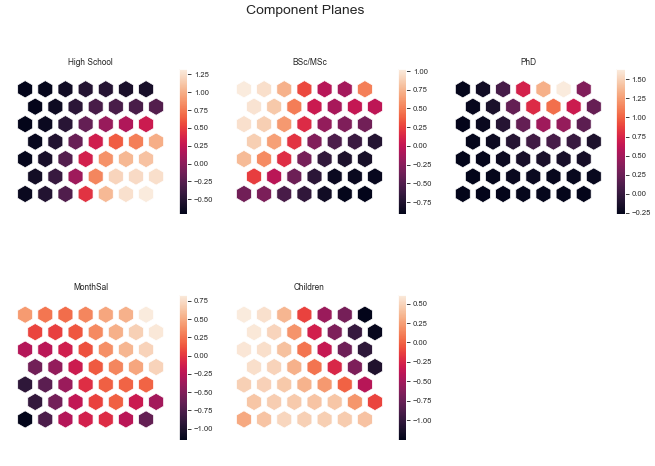

In [21]:
sns.set()
view2D = View2D(12,12,"", text_size=10)
view2D.show(sm, col_sz=3, what='codebook')
plt.subplots_adjust(top=0.90)
plt.suptitle("Component Planes", fontsize=20)
plt.show()

* U-Matrix

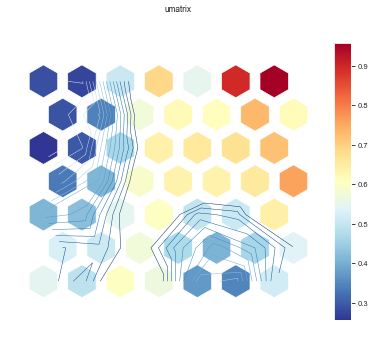

In [22]:
u = sompy.umatrix.UMatrixView(9, 9, 'umatrix', show_axis=True, text_size=8, show_text=True)

UMAT = u.show(
    sm, 
    distance=2, 
    row_normalized=False, 
    show_data=False, 
    contour=True 
)

#### K-Means on top of SOM Units

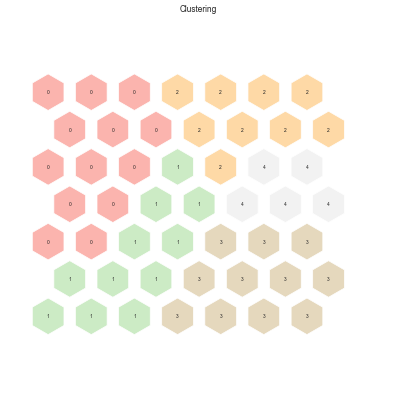

In [23]:
kmeans = KMeans(n_clusters=5, init='k-means++', n_init=20, random_state=42)
nodeclus_labels = kmeans.fit_predict(sm.codebook.matrix)
sm.cluster_labels = nodeclus_labels  # setting the cluster labels of sompy

hits = HitMapView(10, 10,"Clustering", text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [24]:
nodes = sm.codebook.matrix
df_nodes = pd.DataFrame(nodes, columns=demo.columns)
df_nodes['label_somkm2'] = nodeclus_labels
df_nodes

,High School,BSc/MSc,PhD,MonthSal,Children,label_somkm2
0,-0.578106,0.506304,0.355251,0.836643,-1.249194,2
1,-0.568282,-0.116557,1.632015,0.541283,-0.693667,2
2,-0.501848,-0.036712,1.341273,0.480363,-0.533474,2
3,-0.512445,0.289786,0.729137,0.337060,-0.114516,2
4,-0.613909,0.732675,0.090503,0.227492,0.353792,0
5,-0.684523,0.958593,-0.179269,0.266724,0.560943,0
6,-0.707922,1.025632,-0.245808,0.433059,0.616066,0
7,-0.266803,-0.005339,0.234590,0.816425,-1.219560,2
8,-0.311975,0.026102,0.685050,0.695388,-0.985385,2
9,-0.312641,-0.105822,1.058262,0.529321,-0.656003,2


In [25]:
bmus_map = sm.find_bmu(np.array(demo))[0]  # get bmus for each observation in df

df_bmus = pd.DataFrame(
    np.concatenate((demo, np.expand_dims(bmus_map,1)), axis=1),
    index=demo.index, columns=np.append(demo.columns,"BMU_somkm2")
)
df_bmus

,High School,BSc/MSc,PhD,MonthSal,Children,BMU_somkm2
0,1.0,0.0,0.0,0.393345,1.0,38.0
1,1.0,0.0,0.0,0.073379,1.0,38.0
2,0.0,0.0,0.0,0.414676,0.0,17.0
3,0.0,1.0,0.0,0.163396,1.0,12.0
4,0.0,1.0,0.0,0.305034,1.0,5.0
...,...,...,...,...,...,...
10236,0.0,0.0,1.0,0.609002,0.0,10.0
10237,0.0,0.0,0.0,0.447526,0.0,17.0
10238,0.0,1.0,0.0,0.551408,1.0,6.0
10239,0.0,0.0,0.0,0.349403,1.0,25.0


In [26]:
df_demo1 = df_bmus.merge(df_nodes['label_somkm2'], 'left', left_on="BMU_somkm2", right_index=True)
df_demo1

,High School,BSc/MSc,PhD,MonthSal,Children,BMU_somkm2,label_somkm2
0,1.0,0.0,0.0,0.393345,1.0,38.0,3
1,1.0,0.0,0.0,0.073379,1.0,38.0,3
2,0.0,0.0,0.0,0.414676,0.0,17.0,1
3,0.0,1.0,0.0,0.163396,1.0,12.0,0
4,0.0,1.0,0.0,0.305034,1.0,5.0,0
...,...,...,...,...,...,...,...
10236,0.0,0.0,1.0,0.609002,0.0,10.0,2
10237,0.0,0.0,0.0,0.447526,0.0,17.0,1
10238,0.0,1.0,0.0,0.551408,1.0,6.0,0
10239,0.0,0.0,0.0,0.349403,1.0,25.0,1


In [27]:
df_demo1.drop(columns='BMU_somkm2').groupby('label_somkm2').mean()

,High School,BSc/MSc,PhD,MonthSal,Children
label_somkm2,,,,,
0,0.000000,1.0,0.000000,0.487450,0.709015
1,0.001874,0.0,0.246721,0.346666,0.794628
2,0.000000,0.0,0.878261,0.682284,0.276522
3,1.000000,0.0,0.000000,0.397474,0.993810
4,1.000000,0.0,0.000000,0.616433,0.000398


#### Hierarchical Clustering on top of SOM Units

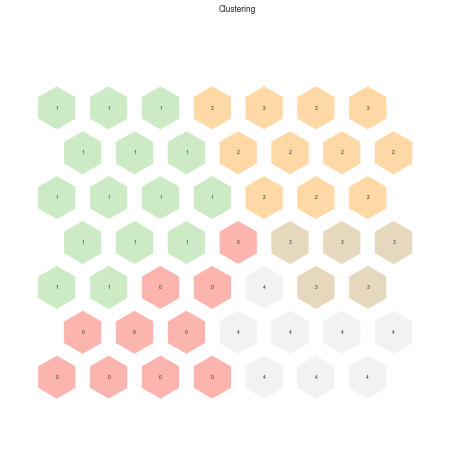

In [28]:
hierclust = AgglomerativeClustering(n_clusters=5, linkage='ward')
nodeclus_labels = hierclust.fit_predict(sm.codebook.matrix)
sm.cluster_labels = nodeclus_labels  # setting the cluster labels of sompy

hits  = HitMapView(12, 12,"Clustering",text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [29]:
nodes = sm.codebook.matrix

df_nodes = pd.DataFrame(nodes, columns=demo.columns)
df_nodes['label_somhc2'] = nodeclus_labels
df_nodes

,High School,BSc/MSc,PhD,MonthSal,Children,label_somhc2
0,-0.578106,0.506304,0.355251,0.836643,-1.249194,2
1,-0.568282,-0.116557,1.632015,0.541283,-0.693667,2
2,-0.501848,-0.036712,1.341273,0.480363,-0.533474,2
3,-0.512445,0.289786,0.729137,0.337060,-0.114516,2
4,-0.613909,0.732675,0.090503,0.227492,0.353792,1
5,-0.684523,0.958593,-0.179269,0.266724,0.560943,1
6,-0.707922,1.025632,-0.245808,0.433059,0.616066,1
7,-0.266803,-0.005339,0.234590,0.816425,-1.219560,2
8,-0.311975,0.026102,0.685050,0.695388,-0.985385,2
9,-0.312641,-0.105822,1.058262,0.529321,-0.656003,2


In [30]:
bmus_map = sm.find_bmu(np.array(demo))[0]

df_bmus = pd.DataFrame(
    np.concatenate((demo, np.expand_dims(bmus_map,1)), axis=1),
    index=demo.index, columns=np.append(demo.columns,"BMU_somhc2")
)
df_bmus

,High School,BSc/MSc,PhD,MonthSal,Children,BMU_somhc2
0,1.0,0.0,0.0,0.393345,1.0,38.0
1,1.0,0.0,0.0,0.073379,1.0,38.0
2,0.0,0.0,0.0,0.414676,0.0,17.0
3,0.0,1.0,0.0,0.163396,1.0,12.0
4,0.0,1.0,0.0,0.305034,1.0,5.0
...,...,...,...,...,...,...
10236,0.0,0.0,1.0,0.609002,0.0,10.0
10237,0.0,0.0,0.0,0.447526,0.0,17.0
10238,0.0,1.0,0.0,0.551408,1.0,6.0
10239,0.0,0.0,0.0,0.349403,1.0,25.0


In [31]:
df_demo2 = df_bmus.merge(df_nodes['label_somhc2'], 'left', left_on="BMU_somhc2", right_index=True)
df_demo2

,High School,BSc/MSc,PhD,MonthSal,Children,BMU_somhc2,label_somhc2
0,1.0,0.0,0.0,0.393345,1.0,38.0,4
1,1.0,0.0,0.0,0.073379,1.0,38.0,4
2,0.0,0.0,0.0,0.414676,0.0,17.0,1
3,0.0,1.0,0.0,0.163396,1.0,12.0,1
4,0.0,1.0,0.0,0.305034,1.0,5.0,1
...,...,...,...,...,...,...,...
10236,0.0,0.0,1.0,0.609002,0.0,10.0,2
10237,0.0,0.0,0.0,0.447526,0.0,17.0,1
10238,0.0,1.0,0.0,0.551408,1.0,6.0,1
10239,0.0,0.0,0.0,0.349403,1.0,25.0,1


In [32]:
df_demo2.drop(columns='BMU_somhc2').groupby('label_somhc2').mean()

,High School,BSc/MSc,PhD,MonthSal,Children
label_somhc2,,,,,
0,0.041667,0.000000,0.000000,0.464946,0.958333
1,0.000000,0.758528,0.062382,0.452109,0.727827
2,0.000000,0.000000,0.878261,0.682284,0.276522
3,1.000000,0.000000,0.000000,0.616433,0.000398
4,1.000000,0.000000,0.000000,0.397474,0.993810


## Evaluation

### Perspective 1: Customer Value

#### K-Means on top of SOM Units

* R^2

In [33]:
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss 

sst = get_ss(df_custval) 
ssw_labels = df_custval.groupby(by='label_somkm').apply(get_ss)  
ssb = sst - np.sum(ssw_labels) 
r2 = ssb / sst
r2

NumExpr defaulting to 8 threads.


0.34550364325563465

* Silhouette Score

In [34]:
silhouette_avg = silhouette_score(df_custval, df_custval['label_somkm'])
silhouette_avg

0.48653957551607147

#### Hierarchical Clustering on top of SOM Units

* R^2

In [35]:
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  

sst = get_ss(df_custval2) 
ssw_labels = df_custval2.groupby(by='label_somhc').apply(get_ss)  
ssb = sst - np.sum(ssw_labels)  
r2 = ssb / sst
r2

0.32253452877650335

* Silhouette Score

In [36]:
silhouette_avg = silhouette_score(df_custval2, df_custval2['label_somhc'])
silhouette_avg

0.45736617724074186

### Perspective 2: Customer Demography

#### K-Means on top of SOM Units

* R^2 

In [37]:
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  

sst = get_ss(df_demo1)  
ssw_labels = df_demo1.groupby(by='label_somkm2').apply(get_ss) 
ssb = sst - np.sum(ssw_labels)  
r2 = ssb / sst
r2

0.9688456678805104

* Silhouette Score

In [38]:
df_demo1['label_somkm2'].value_counts()

0    4803
3    2488
1    1601
4    1004
2     345
Name: label_somkm2, dtype: int64

In [39]:
silhouette_avg = silhouette_score(df_demo1, df_demo1['label_somkm2'])
silhouette_avg

0.6746715149755146

#### Hierarchical Clustering on top of SOM Units

* R^2 

In [40]:
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  

sst = get_ss(df_demo2)  
ssw_labels = df_demo2.groupby(by='label_somhc2').apply(get_ss) 
ssb = sst - np.sum(ssw_labels)  
r2 = ssb / sst
r2

0.82161897444798

* Silhouette Score

In [41]:
silhouette_avg = silhouette_score(df_demo2, df_demo2['label_somhc2'])
silhouette_avg

0.27344218281455046

## Cluster Visualization

In [42]:
from sklearn.manifold import TSNE

def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(s=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

In [43]:
df_demo2.drop(columns='BMU_somhc2').groupby('label_somhc2').mean()

,High School,BSc/MSc,PhD,MonthSal,Children
label_somhc2,,,,,
0,0.041667,0.000000,0.000000,0.464946,0.958333
1,0.000000,0.758528,0.062382,0.452109,0.727827
2,0.000000,0.000000,0.878261,0.682284,0.276522
3,1.000000,0.000000,0.000000,0.616433,0.000398
4,1.000000,0.000000,0.000000,0.397474,0.993810


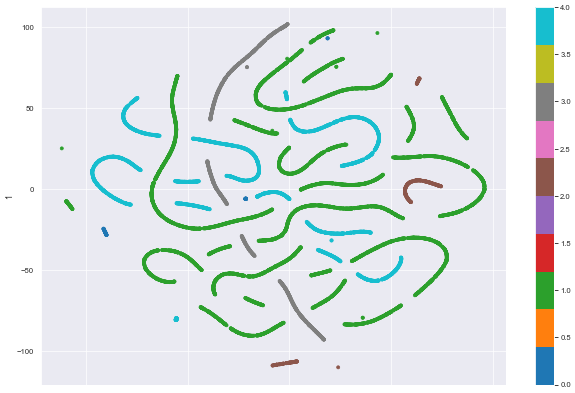

In [44]:
two_dim = TSNE(random_state=42).fit_transform(df_demo2)
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df_demo2['label_somhc2'], colormap='tab10', figsize=(15,10))
plt.show()